# Exploring neoantigen data

- neoAg rate for clonal vs subclonal mutations
- High-expressing rate vs low expressing rate wrt clonality? 

**Next steps** <br>
- Looking at paired RNA data

In [125]:
library(ggplot2)
setwd('/Volumes/yjiao/prepost/reneoantigendetection/out/')
options(jupyter.plot_mimetypes = 'image/png')

### Notes on format of tsv files
- These are the results of the neoantigen pipeline
- Contains all samples, all ccfs, and tpms
- There are multiple peptides for each gene
- Format was created for max flexibility in terms of what we want to visualize, at the cost of high redundancy/ storage space

## Mutant neoantigen affinity vs wildtype neoantigen

**Note** *McGranahan et al* seems to just define neoantigen as anything with mut_aff <= 500. So we'll do the same here.

Old definiton: here a neoantigen is defined as any peptide with min mutant affinity (over all HLA types) <= 500, and min wildtype affinity (also over all HLA types) > 500 *AND* at least 3x greater than mutant affinity.

In [ ]:
files <- list.files(pattern='.tsv')
patients <- sapply(files, function(x) {
    strsplit(x, '\\.')[[1]][1]
})
names(files) <- patients

cutoff <- 500
#sapply(patients, function(pID){
pID <- '208T'
neoag <- read.table(files[pID], header=TRUE, sep='\t', stringsAsFactors = FALSE)

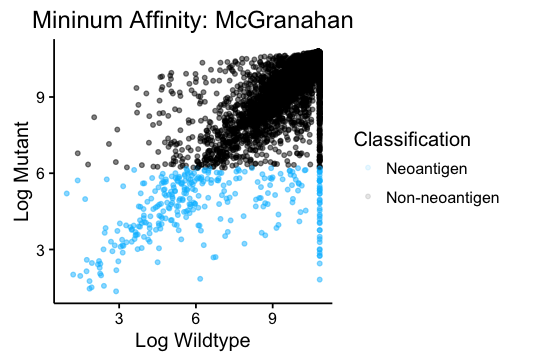

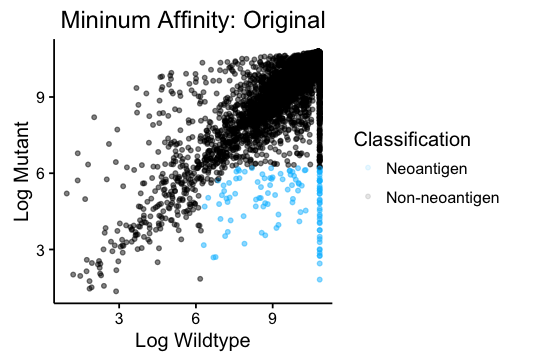

In [170]:
options(repr.plot.width=4.5, repr.plot.height=3)
neoag$is_neoantigen <- neoag$min_aff_mt <= cutoff # McGranahan definition
neoag$is_neoantigen2 <- neoag$min_aff_mt <= cutoff & neoag$min_aff_wt > cutoff & neoag$min_aff_wt >= 3*neoag$min_aff_mt # old definition

c <- ggplot(neoag, aes(x=log(min_aff_wt), y=log(min_aff_mt)))
c + geom_point(alpha=.1, aes(color=is_neoantigen), size=1) +
    labs(title='Mininum Affinity: McGranahan', y='Log Mutant', x='Log Wildtype') +
    theme_classic() +
    scale_color_manual(values=c('#000000','#00BFFF'),
                     name='Classification',
                     breaks=c(TRUE, FALSE),
                     labels=c('Neoantigen', 'Non-neoantigen'))

c <- ggplot(neoag, aes(x=log(min_aff_wt), y=log(min_aff_mt)))
c + geom_point(alpha=.1, aes(color=is_neoantigen2), size=1) +
    labs(title='Mininum Affinity: Original', y='Log Mutant', x='Log Wildtype') +
    theme_classic() +
    scale_color_manual(values=c('#000000','#00BFFF'),
                     name='Classification',
                     breaks=c(TRUE, FALSE),
                     labels=c('Neoantigen', 'Non-neoantigen'))
#})

## Mutant/wildtype affinity vs TPM (TCGA median)
For TPM, since there can be multiple peptides per gene, but each peptide will have the exact same TPM, we want to group all peptides by gene, and plot each gene only once.

### wildtype aff vs TPM <br>
There seems to be no difference

### mutant aff vs TPM <br>
Weirdly, neoantigens appear to be expressed more highly??
- More highly expressed genes tend to be mutated more frequently?
- This affect might go away once we look at the paired RNAseq data?

In [173]:
groups <- tapply(1:nrow(neoag), neoag$Hugo_Symbol, function(idx){
    temp <- neoag[idx[1],]
    temp$min_aff_mt <- min(neoag[idx,]$min_aff_mt)
    temp$min_aff_wt <- min(neoag[idx,]$min_aff_mt)
    temp
})
groups <- do.call(rbind, groups)

Warning message:
: Removed 32 rows containing missing values (geom_point).Warning message:
: Removed 87 rows containing non-finite values (stat_boxplot).

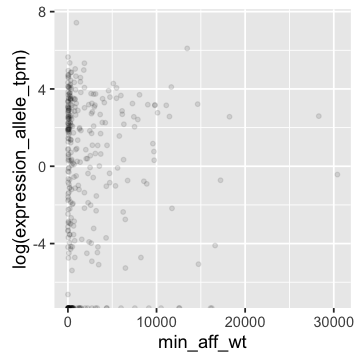

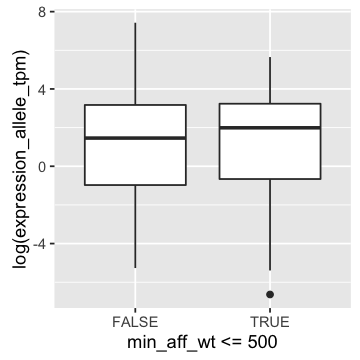

In [174]:
options(repr.plot.width=3, repr.plot.height=3)
c <- ggplot(groups, aes(x=min_aff_wt, y=log(expression_allele_tpm)))
c + geom_point(size=1, alpha=.1) + scale_alpha(range = c(0,1))
c <- ggplot(groups, aes(x=min_aff_wt <= 500, y=log(expression_allele_tpm)))
c + geom_boxplot()

In [187]:
is_neoantigen <- rep('YES', length(groups$is_neoantigen))
is_neoantigen[groups$is_neoantigen] <- 'NO'
is_neoantigen <- as.factor(is_neoantigen)
t.test(groups$expression_allele_tpm ~ is_neoantigen )


	Welch Two Sample t-test

data:  groups$expression_allele_tpm by is_neoantigen
t = 1.211, df = 15.818, p-value = 0.2437
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -21.05347  77.03820
sample estimates:
 mean in group NO mean in group YES 
         49.74466          21.75229 


Warning message:
: Removed 32 rows containing missing values (geom_point).Warning message:
: Removed 87 rows containing non-finite values (stat_boxplot).

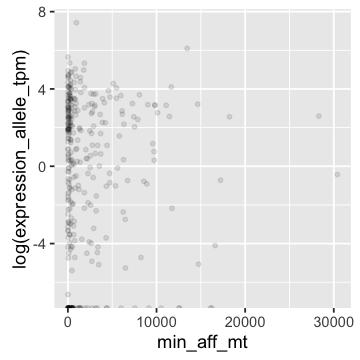

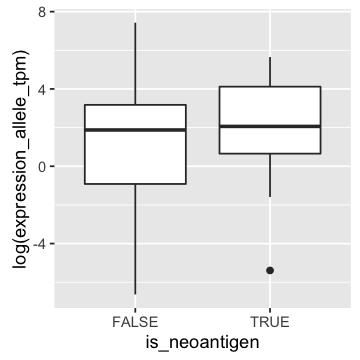

In [139]:
c <- ggplot(groups, aes(x=min_aff_mt, y=log(expression_allele_tpm)))
c + geom_point(size=1, alpha=.1) + scale_alpha(range = c(0,1))
c <- ggplot(groups, aes(x=is_neoantigen, y=log(expression_allele_tpm)))
c + geom_boxplot()

## Distributions of CCF based on neoantigen classification

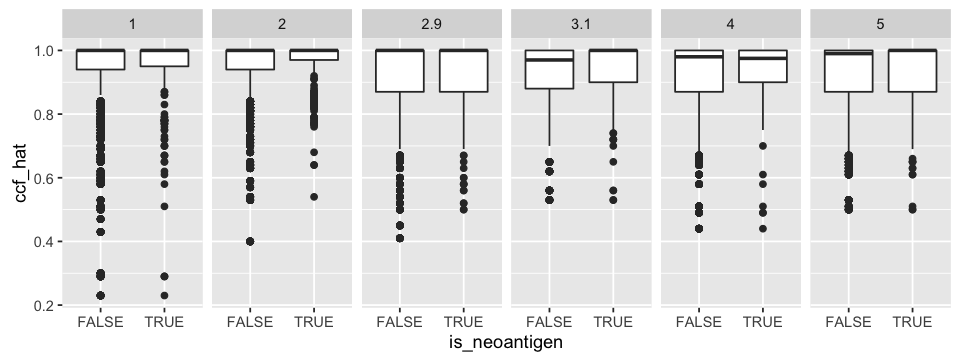

In [171]:
options(repr.plot.width=8, repr.plot.height=3)
c <- ggplot(neoag[neoag$ccf_hat > 0,], aes(x=is_neoantigen, y=ccf_hat)) #filter out all the ccf_hat = 0's
c + geom_boxplot() + facet_wrap(~order, nrow=1)


## Neoantigen rate by clonality
- Arbitrariy define ccf based on **CCF_threshold** as "subclonal"
- The plot below has the threshold on the x axis, and the rate on the y axis
- **THIS IS DEPENDENT ON HOW WE DEFINE NEOANTIGENS!!!**
- New definition from *McGranahan et al*: only post treatment sample (timepoint 2) shows any separation between neoantigen rate in clonal vs nonclonal mutations, and we have MORE neoantigens in CLONAL populations
- Our old definition of neoantigen: For most conditions, it does look like the neoantigen rate is higher at lower CCFs at all time points except for post-treatment (timepoint 2). At timepoint 2, the patient curiously has higher neoantigen rates at clonal positions.

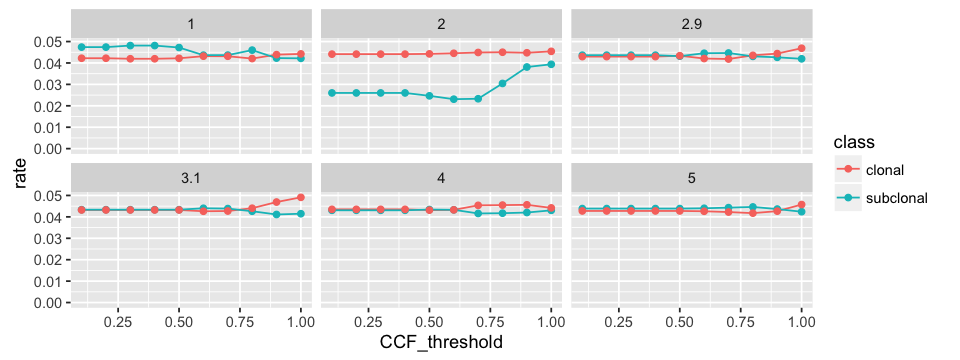

In [165]:
options(repr.plot.width=8, repr.plot.height=3)
neorate <- lapply(unique(neoag$order), function(i){
    ineoag <- neoag[neoag$order == i,]
    neorate <- lapply(seq(0.1,1,.1), function(thresh){
        subclonal <- ineoag$ccf_hat < thresh
        dat1 <- sum(ineoag[subclonal, 'is_neoantigen'])/sum(subclonal)
        dat2 <- sum(ineoag[!subclonal, 'is_neoantigen'])/sum(!subclonal)
        out <- data.frame(CCF_threshold=c(thresh, thresh))
        out$rate <- c(dat1, dat2)
        out$order <- c(i, i)
        out$class <- c('subclonal', 'clonal')
        out
    })
    neorate <- do.call(rbind, neorate)
})
neorate <- do.call(rbind, neorate)

c <- ggplot(neorate, aes(x=CCF_threshold, color=class, y=rate))
c + 
    geom_line() + 
    geom_point() +
    expand_limits(y=0) +
    facet_wrap(~order)

#neoag$is_neoantigen <- neoag$min_aff_mt <= cutoff & neoag$min_aff_wt > cutoff & neoag$min_aff_wt >= 3*neoag$min_aff_mt

!!! THIS IS REALLY WEIRD:

If we revert to our previous definition of neoantigen, then thsi trend reverses:

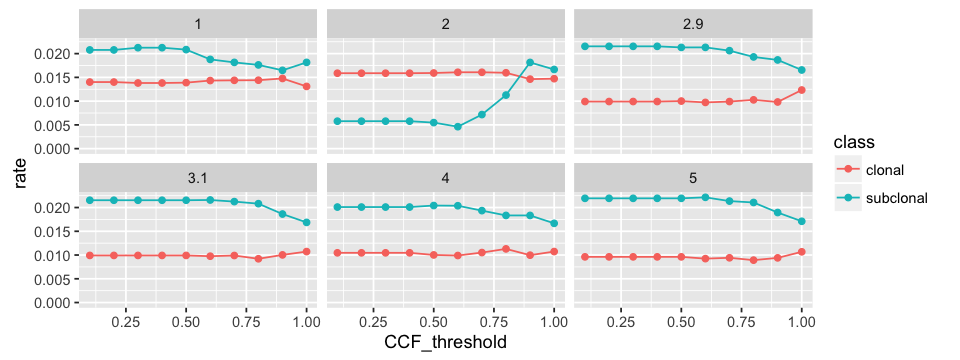

In [164]:
options(repr.plot.width=8, repr.plot.height=3)
neorate <- lapply(unique(neoag$order), function(i){
    ineoag <- neoag[neoag$order == i,]
    neorate <- lapply(seq(0.1,1,.1), function(thresh){
        subclonal <- ineoag$ccf_hat < thresh
        dat1 <- sum(ineoag[subclonal, 'is_neoantigen2'])/sum(subclonal)
        dat2 <- sum(ineoag[!subclonal, 'is_neoantigen2'])/sum(!subclonal)
        out <- data.frame(CCF_threshold=c(thresh, thresh))
        out$rate <- c(dat1, dat2)
        out$order <- c(i, i)
        out$class <- c('subclonal', 'clonal')
        out
    })
    neorate <- do.call(rbind, neorate)
})
neorate <- do.call(rbind, neorate)

c <- ggplot(neorate, aes(x=CCF_threshold, color=class, y=rate))
c + 
    geom_line() + 
    geom_point() +
    expand_limits(y=0) +
    facet_wrap(~order)


## Distribution of neoantigens per gene

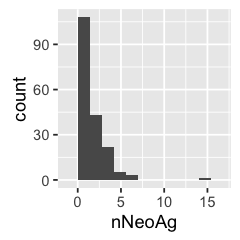

In [159]:
options(repr.plot.width=2, repr.plot.height=2)
nsamples <- length(unique(neoag$order))
ags <- neoag[neoag$is_neoantigen,]
grouped <- tapply(1:nrow(ags), ags$Hugo_Symbol, function(idx){ ags[idx,]})
nNeoPerGene <- data.frame(nNeoAg = sapply(grouped, nrow)/nsamples)

ggplot(nNeoPerGene, aes(x=nNeoAg)) + geom_histogram(bins=10)